# Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import tensorflow as tf
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.stats.api import (het_breuschpagan, het_goldfeldquandt, het_white)
import statsmodels.api as sm
from statsmodels.tsa.api import AutoReg
from scipy.stats import boxcox
from sklearn.linear_model import(LinearRegression, ElasticNet, 
                                 Ridge, Lasso, HuberRegressor)
from sktime.performance_metrics.forecasting import(MeanAbsolutePercentageError, 
                                                   MeanSquaredError, MeanAbsoluteScaledError)


2023-11-10 10:33:35.377118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
medium_df = pd.read_csv("../dataset/partitions/medium_partition.csv", index_col=False)


# Data Processing

In [3]:
# Taking values in dataset after collection gap
medium_df_copy = medium_df.copy()

# convert date to time index
medium_df_copy['date'] = pd.to_datetime(medium_df['date'].astype(np.int64), unit='s') 
medium_df_copy.set_index('date', inplace=True)

# remove features with no variance (reducing the number of features from 31 to 22)
filter = medium_df_copy.std() == 0
features_to_drop = medium_df_copy.columns[filter]
medium_df_copy.drop(features_to_drop, axis=1, inplace=True)

# Sort time index
medium_df_copy.sort_index(inplace=True)
medium_df_copy.describe().transpose() 


,count,mean,std,min,25%,50%,75%,max
avg_alloc_mem,43064.0,113270.074684,23108.402079,0.000000,96666.666667,112000.000000,126292.571429,240000.000000
avg_allocated_cpus_per_job,43065.0,794.927460,232.415983,-1.000000,638.930362,767.309973,906.448980,2880.000000
avg_allocated_nodes_per_job,43065.0,3.104838,0.909252,-1.000000,2.495822,2.997305,3.540816,11.250000
node_total,41152.0,1307.899762,117.422175,3.000000,1310.000000,1353.000000,1363.000000,1379.000000
avg_cpus_load_lower,43064.0,61.410456,132.527736,0.000000,32.154688,45.860000,62.233750,1664.106667
nodes,41152.0,1307.899762,117.422175,3.000000,1310.000000,1353.000000,1363.000000,1379.000000
avg_cpus_load_upper,43064.0,147.473159,240.931443,0.020000,89.327750,104.902778,123.887833,10842.160000
avg_execution_time_per_job,43065.0,53530.705273,13213.540964,-1.000000,44689.482759,52207.138408,61474.898048,186230.188144
avg_free_mem_lower,43064.0,181998.009400,21909.666653,7658.000000,172406.516667,186310.285714,196677.066667,246061.000000
avg_free_mem_upper,43064.0,233872.656079,9771.300881,160283.750000,229192.750000,235711.666667,240720.400000,249787.000000


In [4]:
def handle_missing_data(df, frequency="5min"):
    return df.resample(frequency).interpolate()

def plot_df_feature(df, feature_name, x_initial=0, x_final=None):
    if x_final is None:
        x_final = len(df)
    y = df[feature_name][x_initial:x_final]
    x = df.index[x_initial:x_final]
    fig, ax = plt.subplots()
    ax.set_xlabel("Time")
    ax.set_ylabel(feature_name)
    fig.set_size_inches(15, 5)
    ax.plot(x, y)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

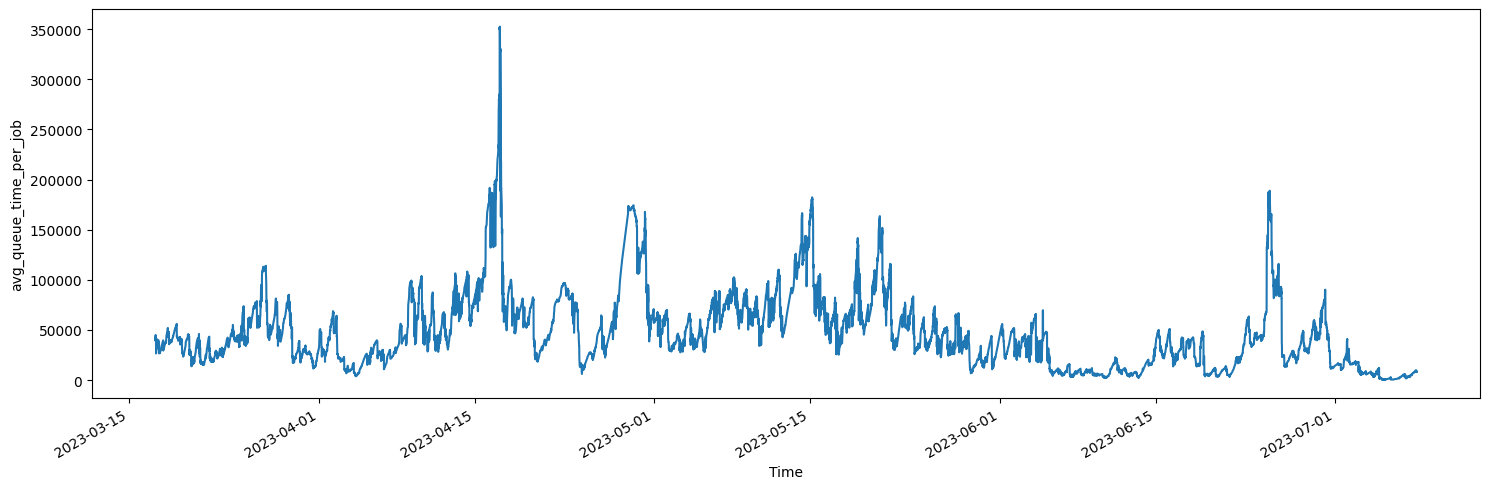

In [87]:
dataset = medium_df_copy[10900:-1000]
#Time series is duplicated every two values, inherited from read medium_df.
#Further investigation in data collection shows data store in Prothemeus shows this befavior, 
#so it is considered normal
# We remove this duplicated data to reduce the size of the dataset
dataset = dataset.drop_duplicates() 
# Filling gaps and resampling
dataset = handle_missing_data(dataset) # Resampling every 5 mins and interpolating

# Time series spans for 4 months
plot_df_feature(dataset, "avg_queue_time_per_job", 0, x_final=len(dataset))

# Data Analysis

## Findings
- 1) queue_time series is not normal
    - However, attempt to transform into normal, for homoskedastic time series, by applying Box-Cox transform does not work
- 2) queue_time series is Heteroskedastic (variance changes over time)
- 3) Analysis of residuals (actual values - predictions) of a AutoRegression model. Results show residuals are not normal.
- 4) queue_time series is not completely random-walk with some short term correlation
- 5) time series is not stationary?, showing some irregular trend, and seasonality is unclear, showing some day and week seasonality not captured by FFT

## Check time series randomnes (random walk)

In [23]:
# Check time series randomnes (random walk) See Peixeiro book (time series forecasting in python)
# Definition: a randow walk is a time series whose first difference is stationary and uncorrelated
# Determine random walk:
    # 1- check stationarity
        # 2- if so, apply difference transformation
    # 3- determine autocorrelation with ACF
        # Correlation? 
            # no -> random walk
            # yes -> no random walk


In [6]:

# Checking stationarity of the time series
# Take first difference (see random walk definition)
dataset_diff = np.diff(dataset['avg_queue_time_per_job'], n=1)
ADF_result = adfuller(dataset_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# ADF statistic << 0, p-value < 0.05 -> first difference stationary

ADF Statistic: -22.717493321934167
p-value: 0.0


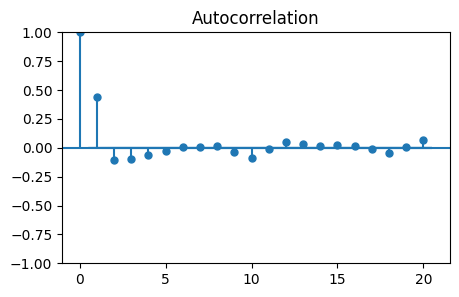

In [7]:
# ACF plot shows some correlation a 1-lag and near-0 oscilation for longer lags, but no non-correlation at all
# first difference is correlated at 1-lag -> No random walk
plt.rc("figure", figsize=(5,3))
fig = plot_acf(dataset_diff, lags=20)

## Check time series seasonality and trend

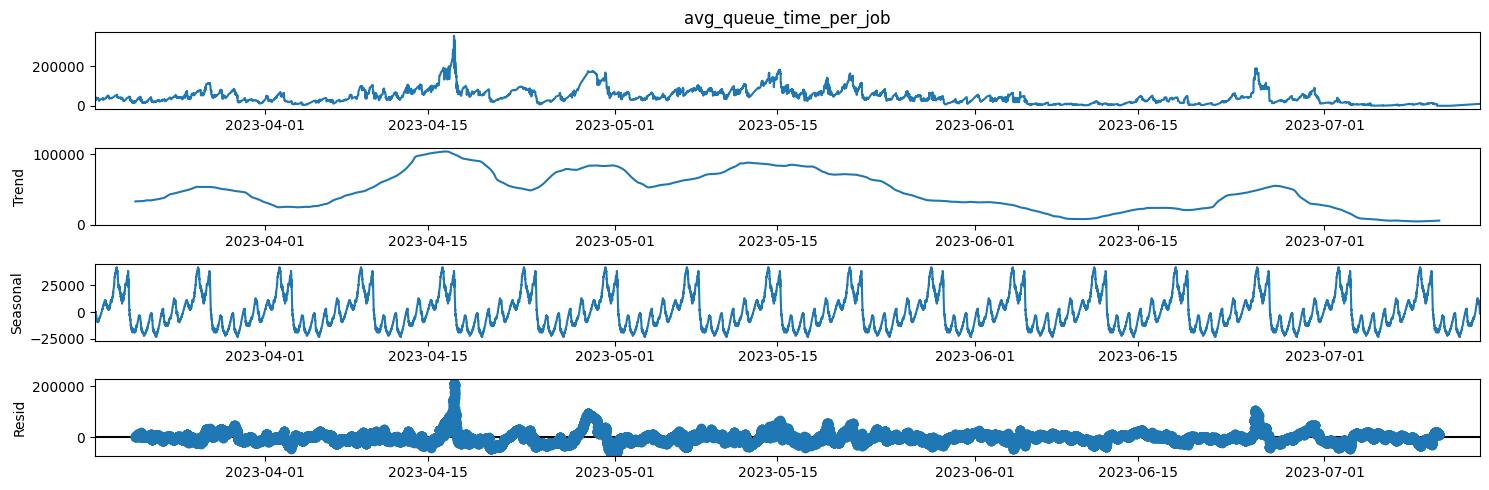

In [8]:

a_day_period = 12*24
a_week_period = a_day_period * 7
a_month_period = 30 * a_day_period
# Trend/Seasonality seems to be stable over time so additive model is selected
sd = seasonal_decompose(dataset['avg_queue_time_per_job'], model='additive', period=a_week_period) 
plt.rc("figure", figsize=(15,5))
fig = sd.plot() # Assign plot to fig to avoid duplicated render


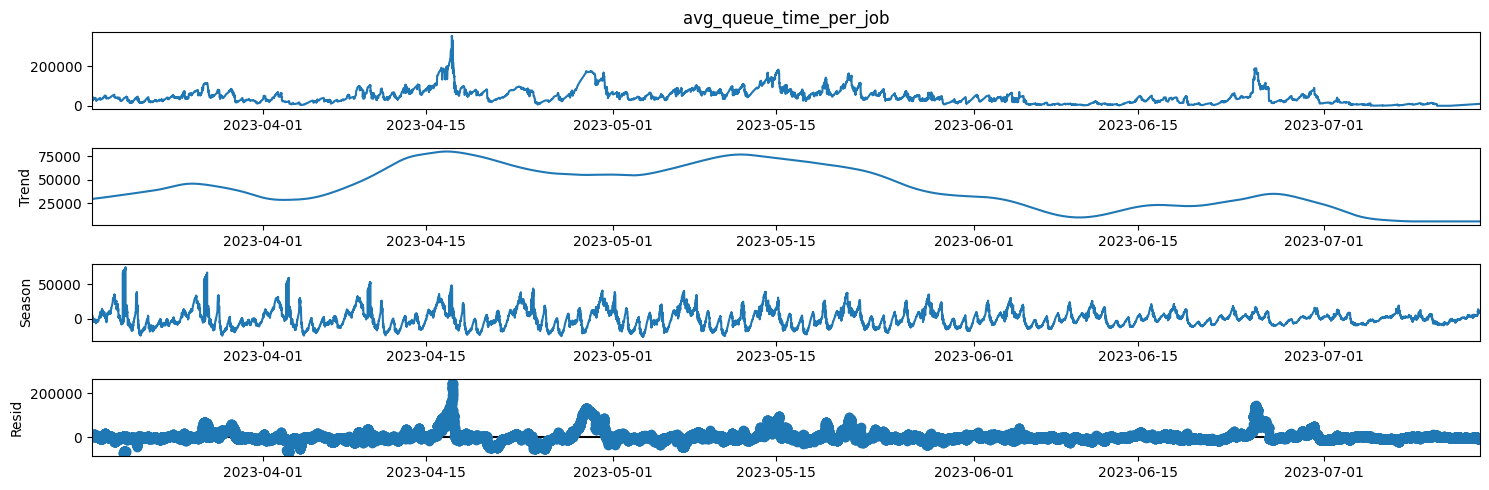

In [18]:
#Using STL decomposition
stld = STL(dataset['avg_queue_time_per_job'], seasonal=13, robust=True, period=a_week_period).fit()
stld.plot(); 

2023-11-07 14:04:10.436505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 14:04:10.437827: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


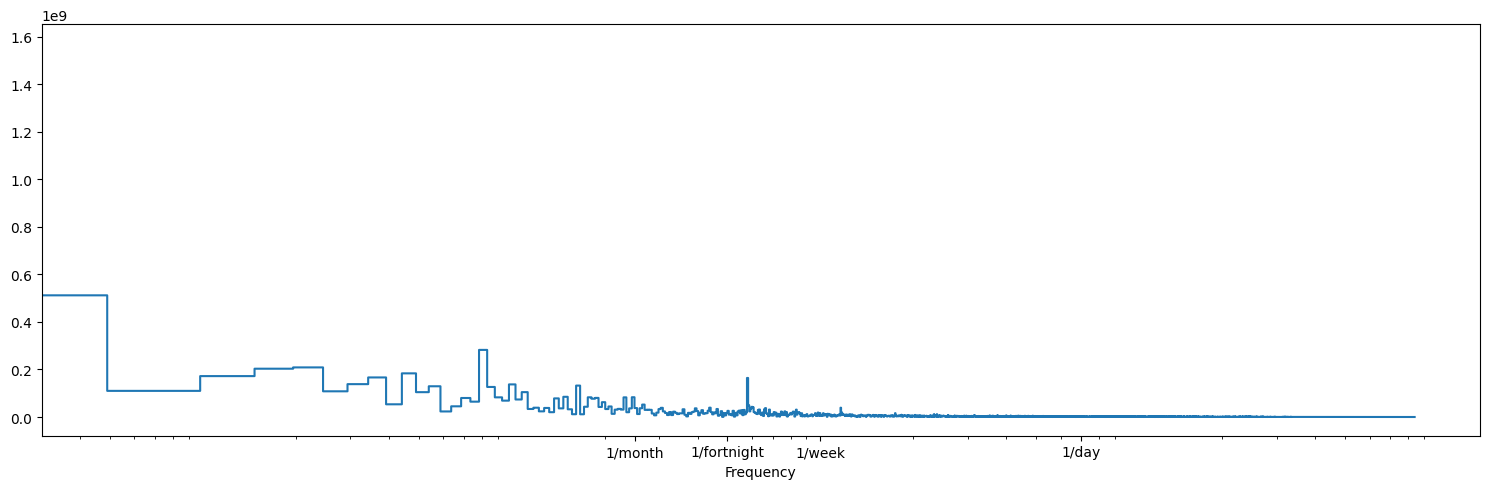

In [10]:
#A day/week seasonality seems to be somehow relevant, 
#however is not detected by FFT, which shows some peak for a frequency larger than a week.
fft = tf.signal.rfft(dataset['avg_queue_time_per_job'])

f_per_dataset = np.arange(0, len(fft))
n_sample_h = len(dataset['avg_queue_time_per_job'])

hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week
f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1/4, 1/2, 1, 7], ['1/month', '1/fortnight', '1/week', '1/day'])
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

## Check time series stationarity

In [9]:
# a stationary time series is defined as a time
# series with a constant mean (μ), a constant variance (σ2) , and a consistence
# covariance (or autocorrelation) between identical distance periods (lags).
# See (Atwan: Time series analysis with python cookbook, chapter 9)
def print_results(output, test='adf'):
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
    output_dict = {
        'Test Statistic': test_score,
        'p-value': pval,
        'Numbers of lags': lags,
        'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
    return pd.Series(output_dict, name=test)

# Augmented Dickey-Fuller (ADF)
adf_output = adfuller(dataset['avg_queue_time_per_job'])

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
kpss_output = kpss(dataset['avg_queue_time_per_job'])

#Not concluding results about time series stationarity
# ADF claims it is stationary, KPSS says it is not
pd.concat(
    [
        print_results(adf_output, 'adf'),
        print_results(kpss_output, 'kpss')
], axis=1)

/home/yosu/miniconda3/envs/timeseriesforecasting/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


,adf,kpss
Test Statistic,-6.541437,5.775912
p-value,0.0,0.01
Numbers of lags,51,111
decision,Stationary,Non-Stationary
Critical Value (1%),-3.430541,0.739
Critical Value (5%),-2.861624,0.463
Critical Value (10%),-2.566815,0.347
Critical Value (2.5%),NaN,0.574


## Check normality (Gaussian distribution)

In [10]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > p_level else 'Not Normal'

normal_args = (np.mean(dataset['avg_queue_time_per_job']),np.std(dataset))
print(is_normal(shapiro(dataset['avg_queue_time_per_job'])))
print(is_normal(normaltest(dataset['avg_queue_time_per_job'])))
print(is_normal(normal_ad(dataset['avg_queue_time_per_job'])))
print(is_normal(kstest_normal(dataset['avg_queue_time_per_job'])))
# print(is_normal(kstest(dataset, cdf='norm',
#     args=(np.mean(dataset), np.std(dataset)))))
# ALL TEST SHOW dataset (average queue time) IS NOT NORMAL
# See (Atwan: Time series analysis with python cookbook, chapter 9)

Not Normal
Not Normal
Not Normal
Not Normal


/home/yosu/miniconda3/envs/timeseriesforecasting/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Check Homeskedasticity

In [11]:
# Checking Homoskedasticity (variance is stable over time) vs heteroskedasticity
# testing for the stability of the variance against the model's residuals

def het_test(model, test=het_breuschpagan):
    lm, lm_pvalue, fvalue, f_pvalue = (
        test(model.resid,
            sm.add_constant(
            model.fittedvalues)
    ))
    return "Heteroskedastic" if f_pvalue < 0.05 else "Homoskedastic"


model = AutoReg(dataset['avg_queue_time_per_job'], lags=1).fit()

print("Test het_breuschpagan: " + het_test(model, test=het_breuschpagan))
# print("Test het_goldfeldquandt: " + het_test(model, test=het_goldfeldquandt))
print("Test het_white: " + het_test(model, test=het_white))


Test het_breuschpagan: Heteroskedastic
Test het_white: Heteroskedastic


## Check feature correlation

[Text(0, 0, 'avg_alloc_mem'),
 Text(0, 1, 'avg_allocated_cpus_per_job'),
 Text(0, 2, 'avg_allocated_nodes_per_job'),
 Text(0, 3, 'node_total'),
 Text(0, 4, 'avg_cpus_load_lower'),
 Text(0, 5, 'nodes'),
 Text(0, 6, 'avg_cpus_load_upper'),
 Text(0, 7, 'avg_execution_time_per_job'),
 Text(0, 8, 'avg_free_mem_lower'),
 Text(0, 9, 'avg_free_mem_upper'),
 Text(0, 10, 'avg_maximum_allocated_cpus_per_job'),
 Text(0, 11, 'avg_maximum_allocated_nodes_per_job'),
 Text(0, 12, 'avg_minimum_requested_cpus_per_job'),
 Text(0, 13, 'avg_minimum_requested_memory_per_job'),
 Text(0, 14, 'avg_minimum_requested_nodes_per_job'),
 Text(0, 15, 'avg_pending_jobs'),
 Text(0, 16, 'node_alloc'),
 Text(0, 17, 'avg_queue_time_per_job'),
 Text(0, 18, 'node_idle'),
 Text(0, 19, 'avg_requested_cpus_per_job'),
 Text(0, 20, 'avg_running_jobs'),
 Text(0, 21, 'avg_time_left_per_job')]

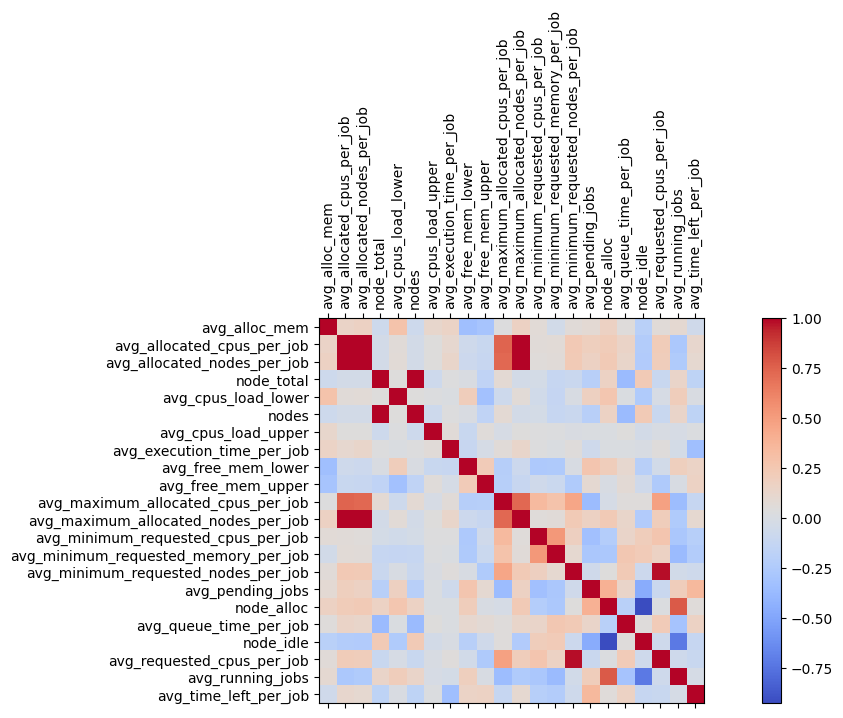

In [13]:
# Compute and display the correlation matrix with pandas
features = dataset.columns
correlation_matrix = dataset.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cmf = ax.matshow(correlation_matrix, cmap='coolwarm')
fig.colorbar(cmf)
plt.xticks(rotation=90)
xaxis = np.arange(len(features))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(features)
ax.set_yticklabels(features)

[Text(0, 0, 'avg_alloc_mem'),
 Text(0, 1, 'avg_allocated_cpus_per_job'),
 Text(0, 2, 'avg_allocated_nodes_per_job'),
 Text(0, 3, 'node_total'),
 Text(0, 4, 'avg_cpus_load_lower'),
 Text(0, 5, 'nodes'),
 Text(0, 6, 'avg_cpus_load_upper'),
 Text(0, 7, 'avg_execution_time_per_job'),
 Text(0, 8, 'avg_free_mem_lower'),
 Text(0, 9, 'avg_free_mem_upper'),
 Text(0, 10, 'avg_maximum_allocated_cpus_per_job'),
 Text(0, 11, 'avg_maximum_allocated_nodes_per_job'),
 Text(0, 12, 'avg_minimum_requested_cpus_per_job'),
 Text(0, 13, 'avg_minimum_requested_memory_per_job'),
 Text(0, 14, 'avg_minimum_requested_nodes_per_job'),
 Text(0, 15, 'avg_pending_jobs'),
 Text(0, 16, 'node_alloc'),
 Text(0, 17, 'avg_queue_time_per_job'),
 Text(0, 18, 'node_idle'),
 Text(0, 19, 'avg_requested_cpus_per_job'),
 Text(0, 20, 'avg_running_jobs'),
 Text(0, 21, 'avg_time_left_per_job')]

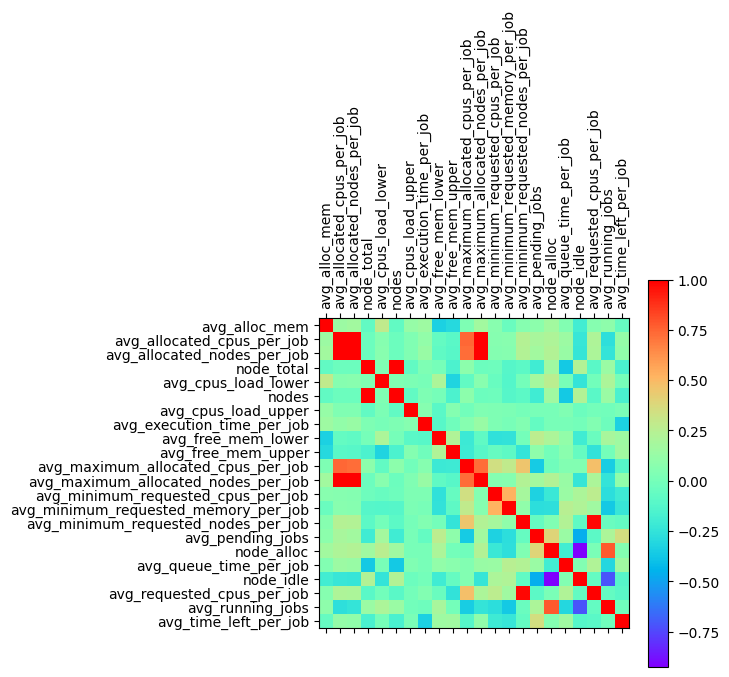

In [14]:
#Compute and display the correlation matrix with numpy Pearson
corr_data = np.corrcoef(dataset.T)
img = plt.matshow(corr_data, cmap=plt.cm.rainbow)
fig.colorbar(img)
#plt.xticks(rotation=90)
#fig.autofmt_xdate(rotation=45)
xaxis = np.arange(len(features))
img.axes.set_xticks(xaxis)
img.axes.set_yticks(xaxis)
img.axes.set_xticklabels(features, rotation = 90)
img.axes.set_yticklabels(features)



In [15]:
# Select the correlation for avg_queue_time_per_job
correlation_matrix['avg_queue_time_per_job'].drop(['avg_queue_time_per_job']).sort_values(ascending=False)

avg_minimum_requested_memory_per_job    0.249045
avg_minimum_requested_nodes_per_job     0.229317
avg_requested_cpus_per_job              0.223799
avg_time_left_per_job                   0.163451
avg_allocated_cpus_per_job              0.150267
avg_minimum_requested_cpus_per_job      0.139824
avg_pending_jobs                        0.136442
avg_allocated_nodes_per_job             0.131770
avg_maximum_allocated_nodes_per_job     0.131770
avg_free_mem_lower                      0.106771
avg_free_mem_upper                      0.079096
node_idle                               0.048626
avg_alloc_mem                           0.048271
avg_maximum_allocated_cpus_per_job      0.047948
avg_cpus_load_upper                     0.044236
avg_execution_time_per_job              0.015012
avg_cpus_load_lower                     0.012664
node_alloc                             -0.191317
avg_running_jobs                       -0.300860
nodes                                  -0.363016
node_total          

# Data Transformation

## Converting time series into homoskedastic and normal

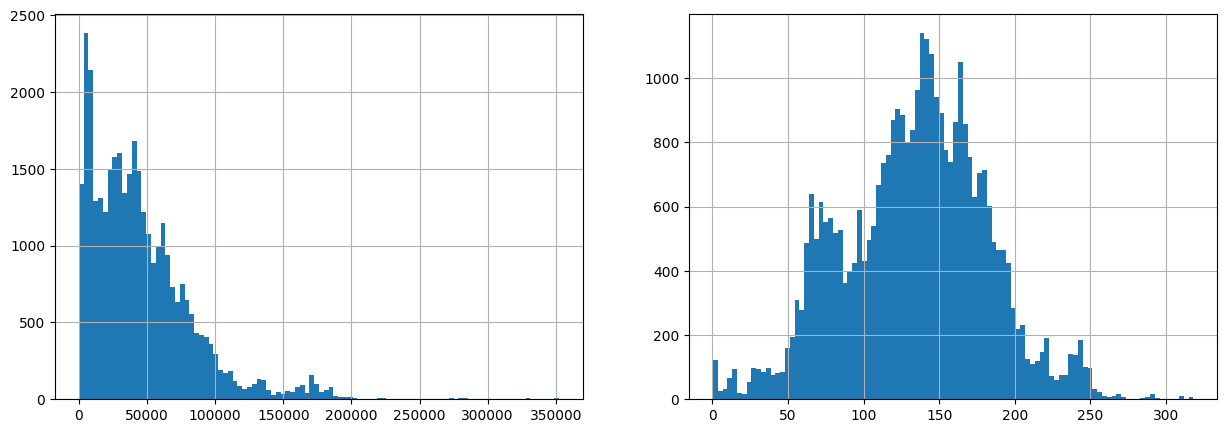

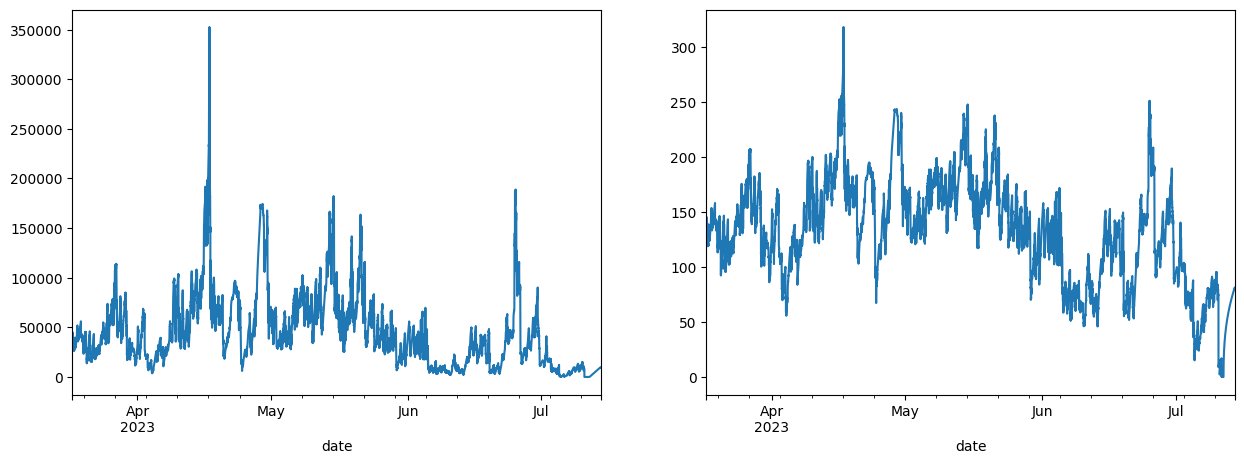

In [16]:

# transforming the dataset
xt, lmbda = boxcox(dataset['avg_queue_time_per_job'])
normal_dataset = pd.Series(xt, index=dataset.index)

# visualizing the original and normal dataset histogram
fig, ax = plt.subplots(1, 2)
dataset['avg_queue_time_per_job'].hist(ax=ax[0], bins=100)
normal_dataset.hist(ax=ax[1], bins=100)
plt.show()

# visualizing the original and normal dataset timeseries
fig, ax = plt.subplots(1, 2)
dataset['avg_queue_time_per_job'].plot(ax=ax[0])
normal_dataset.plot(ax=ax[1])
plt.show()


In [17]:
# However, in this case the boxcox transformation fails on creating a normally distributed time series, as detected by the shapiro test
print(is_normal(shapiro(normal_dataset)))

Not Normal


/home/yosu/miniconda3/envs/timeseriesforecasting/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Feature Selection: Dropping uncorrelated features

In [18]:
# select features (anti)correlated in more than 20%
correlation_threshold = 0.2
correlated_features = correlation_matrix['avg_queue_time_per_job'][correlation_matrix['avg_queue_time_per_job'].abs()>correlation_threshold].index.to_list()
correlated_dataset = dataset[correlated_features].copy()
correlated_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
node_total,34283.0,1297.420048,124.406930,98.000000,1294.000000,1347.000000,1359.000000,1374.000000
nodes,34283.0,1297.420048,124.406930,98.000000,1294.000000,1347.000000,1359.000000,1374.000000
avg_minimum_requested_memory_per_job,34283.0,214031.773603,33052.420346,75512.334807,197043.187450,231397.556818,235855.494354,240000.000000
avg_minimum_requested_nodes_per_job,34283.0,3.404371,2.188844,-1.000000,1.723684,3.060853,4.260580,13.333333
avg_queue_time_per_job,34283.0,45903.394469,38287.979839,1.338415,17738.624891,38554.019516,63331.290159,352544.642276
avg_requested_cpus_per_job,34283.0,424.621946,290.394660,-1.000000,190.598510,375.854545,542.567164,2048.500000
avg_running_jobs,34283.0,304.582169,107.109122,0.000000,232.000000,312.000000,380.000000,695.000000


# Data Forecasting

## Multistep forecasting with multi-window

In [104]:
def multiple_output(df, window_in, window_out):
    d = df.values
    x = []
    y = []
    n = len(df)
    idx = df.index[:-window_in]
    for start in range(n-window_in):
        end = start + window_in
        out = end + window_out
        x.append(d[start:end].ravel())
        y.append(d[end:out].ravel())
        
    cols_x = [f'x_{i}' for i in range(1, window_in+1)]
    cols_y = [f'y_{i}' for i in range(1, window_out+1)]

    df_xs = pd.DataFrame(x,  index=idx, columns=cols_x)
    df_y = pd.DataFrame(y,index=idx, columns=cols_y)
    return pd.concat([df_xs, df_y], axis=1).dropna()

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

class Standardize:
    def __init__(self, test_split=0.15):
        self.split = test_split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * self.split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]
    

def train_model(train_scaled_df, test_scaled_df, win_in, win_out, scaler, regressor, reg_name):
    X_train, y_train = train_scaled_df.iloc[: , :win_in], train_scaled_df.iloc[:, win_out:]
    X_test, y_test = test_scaled_df.iloc[: , :win_in], test_scaled_df.iloc[:, win_out:]
    
    print(f'training {reg_name} ...')
    regressor.fit(X_train, y_train)
    
    # Error metrics
    mse = MeanSquaredError()
    mape = MeanAbsolutePercentageError()
    mase = MeanAbsoluteScaledError()
    
    # Predict and inverse scale
    yhat = scaler.inverse_y(regressor.predict(X_test))
    y_test = scaler.inverse_y(y_test)
        
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata

def train_different_models(train, test, win_in, win_out, scaler, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train, test, win_in, win_out, scaler, regressor, reg_name))
    return results

    
def show_forecast_multi_window(train_scaled_df, test_scaled_df, target_df, win_in, win_out, scaler, regressor, reg_name, period):
    X_train, y_train = train_scaled_df.iloc[: , :win_in], train_scaled_df.iloc[:, win_out:]
    X_test, y_test = test_scaled_df.iloc[: , :win_in], test_scaled_df.iloc[:, win_out:]
    print(f'training {reg_name} ...')
    regressor.fit(X_train, y_train)

    # Predict and inverse scale
    pred = scaler.inverse_y(regressor.predict(X_test)[-1])

    # Show
    dates = target_df.index
    inputs, outputs = dates[:win_in], dates[win_out:]
    pd.Series(target_df.values, index=dates).plot(style='k--', alpha=0.5)
    pd.Series(pred, index=outputs).plot(style='k-o')
    plt.title(f'Multiple Output for Multi-Step Forecasting with {reg_name}')
    plt.legend(['Actual', 'Forecast'])
    plt.show()

In [105]:
period = a_day_period
win_in, win_out = period, period
timeseries = dataset['avg_queue_time_per_job']
target_df = timeseries.tail(2*period)

df_period = multiple_output(timeseries, win_in, win_out)

train_df, test_df = split_data(df_period, test_split=0.10)
scaler = Standardize()
train_scaled_df, test_scaled_df = scaler.fit_transform(train_df, test_df)

regressors = {
    'Linear Regression': LinearRegression(),
    'Elastic Net': ElasticNet(0.5),
    'Ridge Regression': Ridge(0.5),
    'Lasso Regression': Lasso(0.5)}

one_step_results = train_different_models(train_scaled_df, test_scaled_df, regressors)

TypeError: train_model() missing 4 required positional arguments: 'scaler', 'regressor', 'reg_name', and 'period'

### Regression forecasting with supervised linear models

training Linear Regression ...


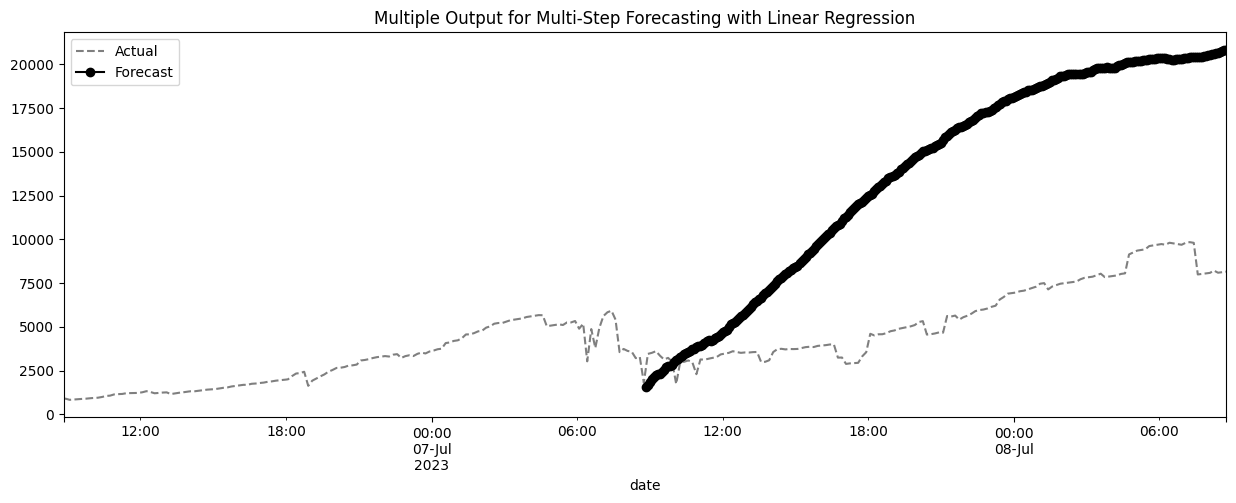

training Elastic Net ...


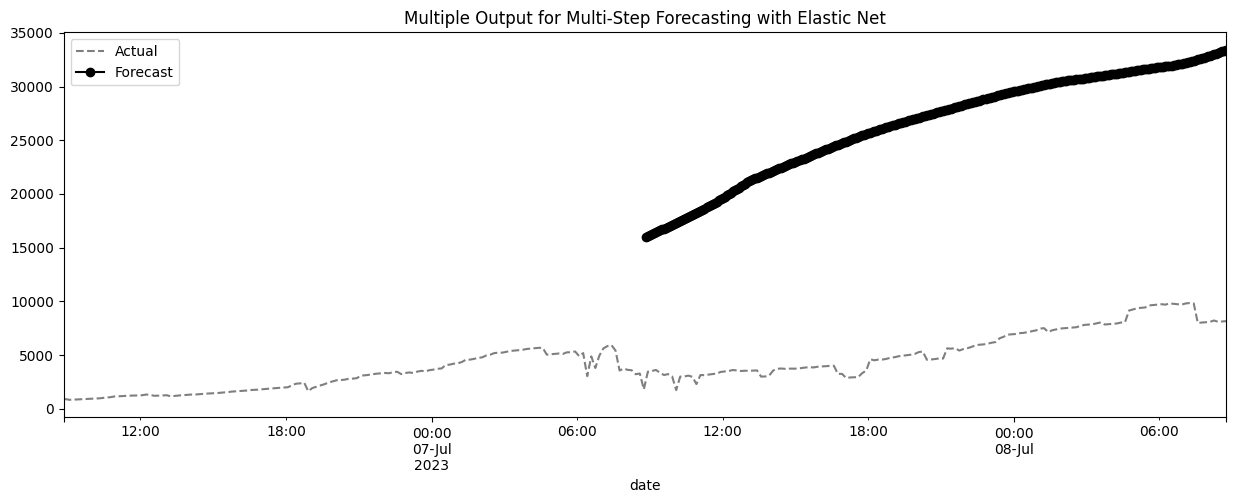

training Ridge Regression ...


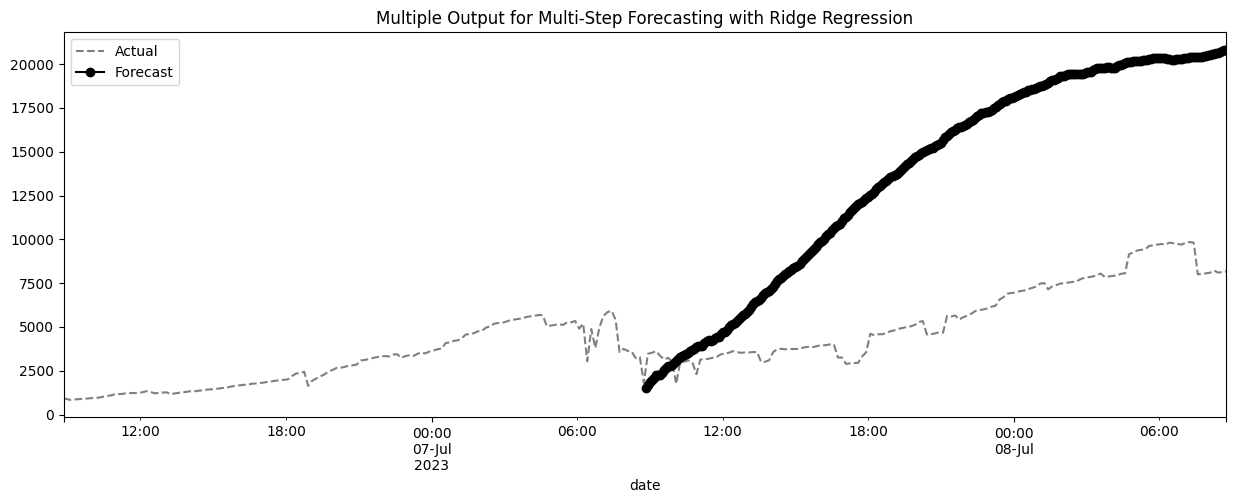

training Lasso Regression ...


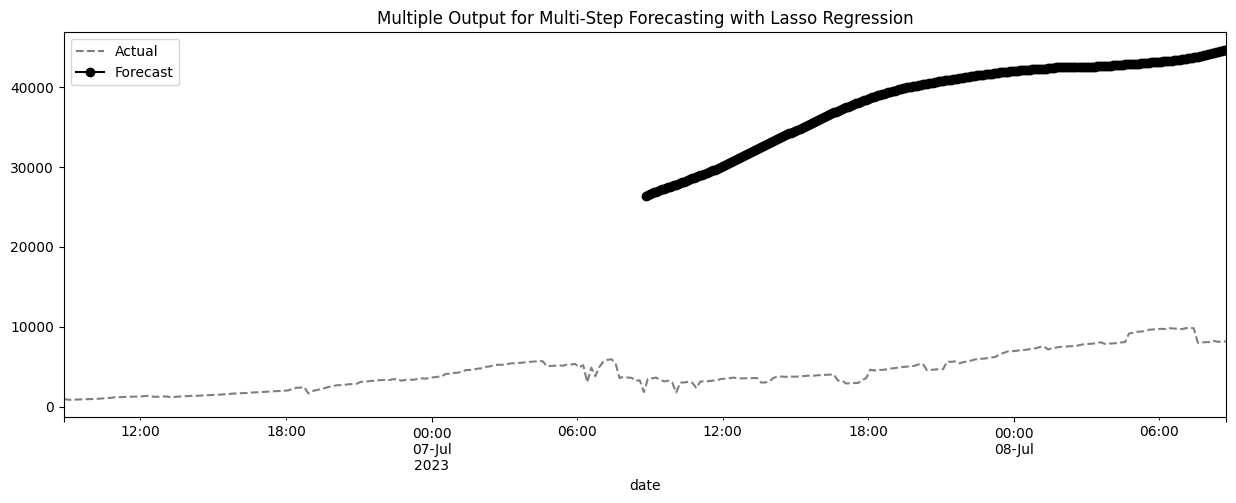

In [103]:
reg_name, regressor = 'Linear Regression', LinearRegression()
show_forecast_multi_window(train_scaled_df, test_scaled_df, target_df, win_in, win_out, scaler, regressor, reg_name, period)

reg_name, regressor = 'Elastic Net', ElasticNet(0.5)
show_forecast_multi_window(train_scaled_df, test_scaled_df, target_df, win_in, win_out, scaler, regressor, reg_name, period)

reg_name, regressor = 'Ridge Regression', Ridge(0.5)
show_forecast_multi_window(train_scaled_df, test_scaled_df, target_df, win_in, win_out, scaler, regressor, reg_name, period)

reg_name, regressor = 'Lasso Regression', Lasso(0.5)
show_forecast_multi_window(train_scaled_df, test_scaled_df, target_df, win_in, win_out, scaler, regressor, reg_name, period)


In [ ]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
one_step_results = pd.DataFrame(one_step_results)
one_step_results[cols].sort_values('MASE')